In [1]:
# import packages
import pandas as pd
import json
#from flat_table import normalize
import ast
import re
import math

import logging
import pandas as pd
import numpy as np
from numpy import random
#import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re

## Working with train set

In [2]:
# load the package
df = pd.read_csv('/project/train_data.csv')
df.head()

,Unnamed: 0,abstract.text_sw,biblio.invention_title.text_sw,claims.claims_sw,yo2
0,98980,disclosure relates hand control input device c...,unknown,a hand control input device comprising a ...,0
1,69824,one aspect present invention directed plant pl...,bacterial spore compositions for industrial uses,a plant or plant part coated with a composi...,1
2,9928,demonstrative embodiments include apparatuses ...,apparatus system and method of setting up an ...,a product comprising one or more tangible c...,0
3,75599,wavelength multiplexing apparatus includes div...,wavelength multiplexing apparatus and method,a wavelength multiplexing apparatus compris...,0
4,95621,first second inputs received first input indic...,method and apparatus for transmitter optimizat...,canceled a system comprising one ...,0


In [3]:
df = df[['abstract.text_sw','biblio.invention_title.text_sw','claims.claims_sw','yo2']]

In [4]:
df.head()

,abstract.text_sw,biblio.invention_title.text_sw,claims.claims_sw,yo2
0,disclosure relates hand control input device c...,unknown,a hand control input device comprising a ...,0
1,one aspect present invention directed plant pl...,bacterial spore compositions for industrial uses,a plant or plant part coated with a composi...,1
2,demonstrative embodiments include apparatuses ...,apparatus system and method of setting up an ...,a product comprising one or more tangible c...,0
3,wavelength multiplexing apparatus includes div...,wavelength multiplexing apparatus and method,a wavelength multiplexing apparatus compris...,0
4,first second inputs received first input indic...,method and apparatus for transmitter optimizat...,canceled a system comprising one ...,0


In [5]:
# split train and test
y = df['yo2']
X = df.drop(columns = 'yo2')

In [6]:
# train and validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [7]:
X_train.shape

(56250, 3)

In [8]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# svm
algorithm = LinearSVC(class_weight='balanced',random_state=42)

# define paramater space
space = dict()
space['calibrated__base_estimator__C'] = [0.1, 1, 10, 100]

# choose number of folds
n_folds = 5

train_pipe = Pipeline([('pipe_tfidf', TfidfVectorizer()),
                ('calibrated', CalibratedClassifierCV(base_estimator=algorithm, cv=5))
                 ])

# perform hyperparameter tuning with randomised grid search, plus
# stratified cross validation
grid = GridSearchCV(estimator=train_pipe,
                  param_grid=space,
                  scoring="roc_auc",
                  n_jobs=-1,
                  cv=n_folds)

In [16]:
# SVM Model on ABSTRACT

# search for best hyperparameterisation
best_model_abs = grid.fit(X_train.iloc[:,0], y_train)

print('Best Hyperparameters: %s' % best_model_abs.best_params_)
print('Best AUC: %s' % best_model_abs.best_score_)

preds_abs = best_model_abs.predict(X_test.iloc[:,0])

print(classification_report(y_test,preds_abs))

Best Hyperparameters: {'calibrated__base_estimator__C': 0.1}
Best AUC: 0.8619973132963967
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     16916
           1       0.73      0.32      0.44      1834

    accuracy                           0.92     18750
   macro avg       0.83      0.65      0.70     18750
weighted avg       0.91      0.92      0.91     18750



In [9]:
# SVM model on TITLE

# search for best hyperparameterisation
best_model_title = grid.fit(X_train.iloc[:,1], y_train)

print('Best Hyperparameters: %s' % best_model_title.best_params_)
print('Best AUC: %s' % best_model_title.best_score_)

preds_title = best_model_title.predict(X_test.iloc[:,1])

print(classification_report(y_test,preds_title))

Best Hyperparameters: {'calibrated__base_estimator__C': 0.1}
Best AUC: 0.7895042673463909
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     16916
           1       0.76      0.20      0.32      1834

    accuracy                           0.92     18750
   macro avg       0.84      0.60      0.64     18750
weighted avg       0.90      0.92      0.89     18750



In [185]:
# pd.DataFrame(preds_title[:,1]).hist(bins=50)

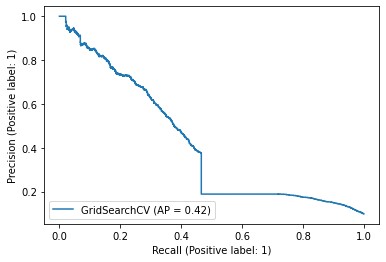

In [19]:
# precision and recall plot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
plot_precision_recall_curve(best_model_title, X_test.iloc[:,1], y_test)

In [20]:
# confusion matrix 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,preds_title)

array([[16799,   117],
       [ 1461,   373]])

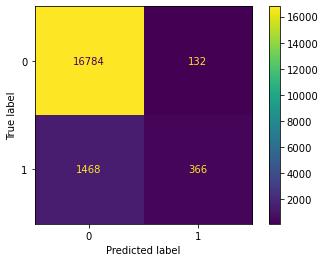

In [24]:
# confusion matrix plot
import sklearn.metrics as metrics
metrics.plot_confusion_matrix(best_model_title, X_test.iloc[:,1], y_test);

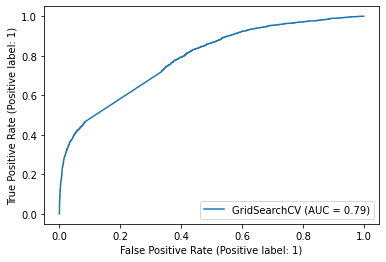

In [25]:
# Roc curve
metrics.plot_roc_curve(best_model_title, X_test.iloc[:,1], y_test)  

In [26]:
pd.DataFrame(preds_title).value_counts()

0    18260
1      490
dtype: int64

In [27]:
# SVM Model on CLAIMS

# search for best hyperparameterisation
best_model_claims = grid.fit(X_train.iloc[:,2], y_train)

print('Best Hyperparameters: %s' % best_model_claims.best_params_)
print('Best AUC: %s' % best_model_claims.best_score_)

preds_claims = best_model_claims.predict(X_test.iloc[:,2])

print(classification_report(y_test,preds_claims))

Best Hyperparameters: {'calibrated__base_estimator__C': 0.1}
Best AUC: 0.8729049618471088
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     16916
           1       0.76      0.34      0.47      1834

    accuracy                           0.93     18750
   macro avg       0.85      0.66      0.72     18750
weighted avg       0.92      0.93      0.91     18750



In [35]:
# SVM Model abstract and claims

# search for best hyperparameterisation
best_model_abs_claims = grid.fit(X_train.iloc[:,0] + " " + X_train.iloc[:,2], y_train)

print('Best Hyperparameters: %s' % best_model_abs_claims.best_params_)
print('Best AUC: %s' % best_model_abs_claims.best_score_)

preds_abs_claims  = best_model_abs_claims.predict(X_test.iloc[:,0] + " " + X_test.iloc[:,2])

print(classification_report(y_test,preds_abs_claims))

Best Hyperparameters: {'calibrated__base_estimator__C': 0.1}
Best AUC: 0.8772344704619293
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     16916
           1       0.76      0.35      0.48      1834

    accuracy                           0.93     18750
   macro avg       0.85      0.67      0.72     18750
weighted avg       0.92      0.93      0.91     18750



In [34]:
# SVM Model title and claims

# search for best hyperparameterisation
best_model_title_claims = grid.fit(X_train.iloc[:,1] + " " + X_train.iloc[:,2], y_train)

print('Best Hyperparameters: %s' % best_model_title_claims.best_params_)
print('Best AUC: %s' % best_model_title_claims.best_score_)

preds_title_claims = best_model_title_claims.predict(X_test.iloc[:,1] + " " + X_test.iloc[:,2])

print(classification_report(y_test,preds_title_claims))

Best Hyperparameters: {'calibrated__base_estimator__C': 0.1}
Best AUC: 0.8749176376225748
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     16916
           1       0.76      0.34      0.47      1834

    accuracy                           0.93     18750
   macro avg       0.85      0.67      0.72     18750
weighted avg       0.92      0.93      0.91     18750



In [33]:
# SVM Model title and abstract

# search for best hyperparameterisation
best_model_title_abs = grid.fit(X_train.iloc[:,0] + " " + X_train.iloc[:,1], y_train)

print('Best Hyperparameters: %s' % best_model_title_abs.best_params_)
print('Best AUC: %s' % best_model_title_abs.best_score_)

preds_title_abs = best_model_title_abs.predict(X_test.iloc[:,0] + " " + X_test.iloc[:,1])

print(classification_report(y_test,preds_title_abs))

Best Hyperparameters: {'calibrated__base_estimator__C': 0.1}
Best AUC: 0.8697712913368771
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     16916
           1       0.74      0.33      0.45      1834

    accuracy                           0.92     18750
   macro avg       0.84      0.66      0.71     18750
weighted avg       0.91      0.92      0.91     18750



In [ ]:
# SVM Model title and abstract and claims

# search for best hyperparameterisation
best_model_tac = grid.fit(X_train.iloc[:,0] + " " + X_train.iloc[:,1] + " " + X_train.iloc[:,2], y_train)

print('Best Hyperparameters: %s' % best_model_tac.best_params_)
print('Best AUC: %s' % best_model_tac.best_score_)

preds_title_abs_claims = best_model_tac.predict(X_test.iloc[:,0] + " " + X_test.iloc[:,1]+ " " + X_test.iloc[:,2])

print(classification_report(y_test,preds_title_abs_claims))

## testing set results for title that has the highest precision

In [30]:
# load the package
test_df = pd.read_csv('/project/test_data.csv')

In [31]:
test_y = test_df['yo2']
test_X = test_df['biblio.invention_title.text_sw']

In [32]:
preds_title = best_model_title.predict(test_X)

print(classification_report(test_y,preds_title))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     22676
           1       0.74      0.22      0.33      2324

    accuracy                           0.92     25000
   macro avg       0.83      0.60      0.65     25000
weighted avg       0.91      0.92      0.90     25000

